# Welcome to PYNQ Audio

## Table of Contents
* [Recording and Playing Audio](#Recording-and-Playing-Audio)
* [Visualising Audio Data](#Visualising-Audio-Data)
* [Basic Digital Signal Processing](#Basic-Digital-Signal-Processing)
* [Google's Speech API](#Google's-Speech-API)

## Install Dependencies

In [ ]:
!apt update
!apt install -y sox ffmpeg flac
!pip3 install gtts pysndfx speechRecognition pydub

In [2]:
import speech_recognition as sr
from pynq.overlays.base import BaseOverlay
from pysndfx import AudioEffectsChain
from gtts import gTTS
from pydub import AudioSegment
from IPython.display import Audio

## Recording and Playing Audio

### 1. Create new audio object

In [3]:
base = BaseOverlay("base.bit")
pAudio = base.audio

### 2. Bypass audio
Users can select either `LINE_IN`, or `HP+MIC` as the input port.
**

In the following example, we choose `LINE_IN`. To choose `MIC`:
```python
pAudio.select_microphone()
```
or choose `LINE_IN`:
```python
pAudio.select_line_in()
```

**Try it first with your earbuds out**

In [4]:
pAudio.select_microphone()

In [5]:
pAudio.bypass(seconds=5)

### 3. Record
Record a 5-second sample and save it into a file.

In [6]:
pAudio.record(5)
pAudio.save("data/recording.wav")

### 4. Load and play
Load a file and play the loaded samples.

In [8]:
pAudio.load("data/recording.wav")
pAudio.play()

### 5. Adding effects
Create a new file with effects added. [Information for effects can be found here](https://github.com/carlthome/python-audio-effects/blob/master/pysndfx/dsp.py)

In [9]:
fx = AudioEffectsChain().delay().reverb()

In [10]:
fx("data/recording.wav","data/recording.ogg")

### 6. Play in notebook
Since the samples are in 24-bit PCM format, 
users can play the audio directly in notebook.

In [11]:
Audio("data/recording.ogg")

## Visualising Audio Data

Users can display the audio data in notebook. In this section we will:

1. Extract the audio signal from the *.wav file.
2. Plot the audio signal's amplitude over time.
3. Plot the audio signal's frequency response. 
4. Plot the spectrogram of the audio signal.

### 1. Extract PCM data from *.wav
The next cell reads the saved audio file and processes it into a `numpy` array.
Note that if the audio sample width is not standard, additional processing
is required. In the following example, the `sample_width` is read from the
wave file itself (24-bit dual-channel PCM audio, where `sample_width` is 3 bytes).

In [12]:
%matplotlib inline
import wave
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq

wav_path = "data/recording.wav"
with wave.open(wav_path, 'r') as wav_file:
    raw_frames = wav_file.readframes(-1)
    num_frames = wav_file.getnframes()
    num_channels = wav_file.getnchannels()
    sample_rate = wav_file.getframerate()
    sample_width = wav_file.getsampwidth()
    
temp_buffer = np.empty((num_frames, num_channels, 4), dtype=np.uint8)
raw_bytes = np.frombuffer(raw_frames, dtype=np.uint8)
temp_buffer[:, :, :sample_width] = raw_bytes.reshape(-1, num_channels, 
                                                    sample_width)
temp_buffer[:, :, sample_width:] = \
    (temp_buffer[:, :, sample_width-1:sample_width] >> 7) * 255
frames = temp_buffer.view('<i4').reshape(temp_buffer.shape[:-1])

### 2. Amplitude over time

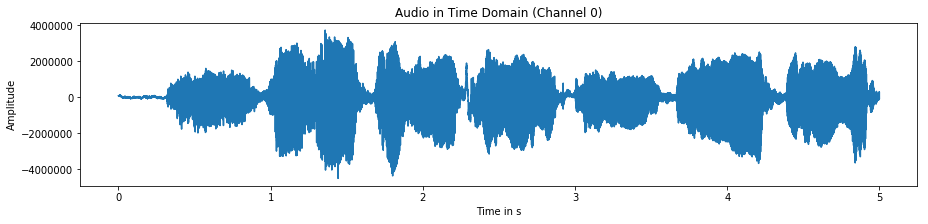

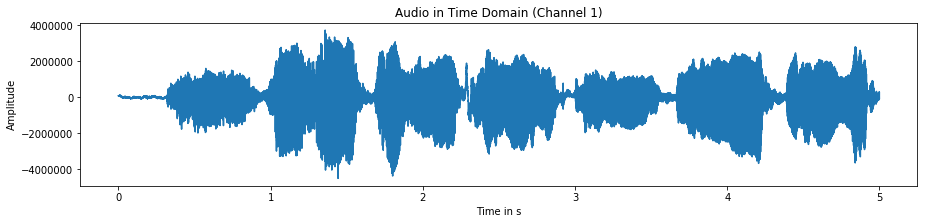

In [13]:
for channel_index in range(num_channels):
    plt.figure(num=None, figsize=(15, 3))
    plt.title('Audio in Time Domain (Channel {})'.format(channel_index))
    plt.xlabel('Time in s')
    plt.ylabel('Amplitude')
    time_axis = np.arange(0, num_frames/sample_rate, 1/sample_rate)
    plt.plot(time_axis, frames[:, channel_index])
    plt.show()

### 3. Frequency spectrum

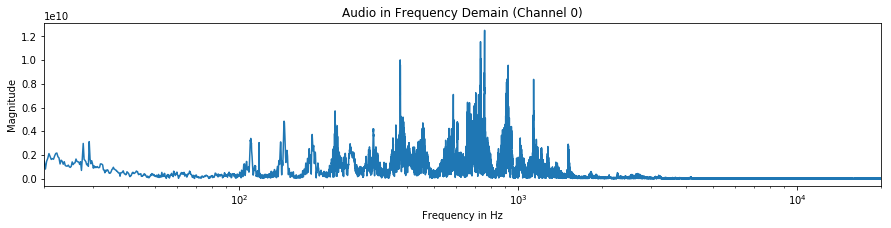

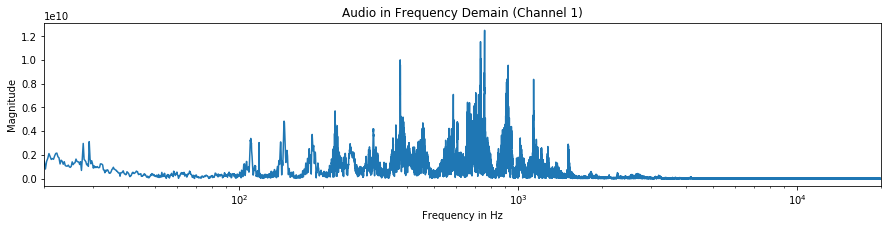

In [14]:
for channel_index in range(num_channels):
    plt.figure(num=None, figsize=(15, 3))
    plt.title('Audio in Frequency Demain (Channel {})'.format(channel_index))
    plt.xlabel('Frequency in Hz')
    plt.xscale('log')
    plt.ylabel('Magnitude')
    temp = fft(frames[:, channel_index])
    yf = temp[1:len(temp)//2]
    xf = np.linspace(0.0, sample_rate/2, len(yf))
    plt.xlim(20,20000)
    plt.plot(xf, abs(yf))
    plt.show()

### 4. Frequency spectrum over time
Use the `classic` plot style for better display.

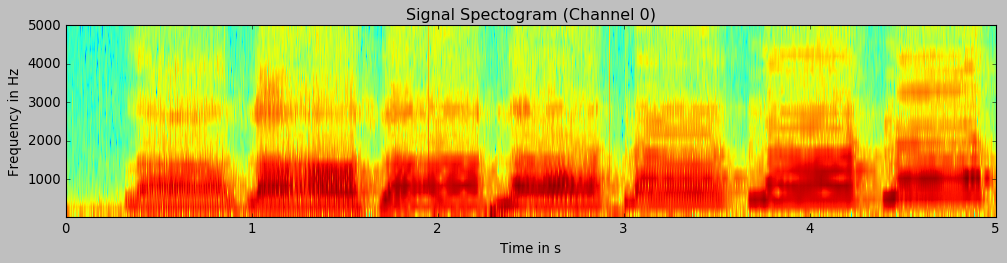

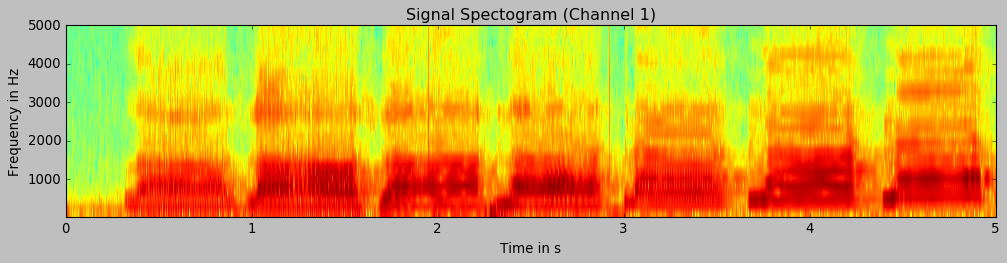

In [15]:
for channel_index in range(num_channels):
    np.seterr(divide='ignore', invalid='ignore')
    matplotlib.style.use("classic")
    plt.figure(num=None, figsize=(15, 3))
    plt.title('Signal Spectogram (Channel {})'.format(channel_index))
    plt.xlabel('Time in s')

    plt.ylabel('Frequency in Hz')
    plt.specgram(frames[:, channel_index], Fs=sample_rate)
    plt.ylim(20,5000)

## Basic Digital Signal Processing
When a signal is in a digital format, we can manipulate it easily using Python and a little digital signal processing (DSP) knowledge.
In this section we will:
1. Create an interference signal using the formula for a sine wave: y(t) = Asin(2πft + φ)
2. Add the interference signal to our recorded audio.
3. Apply a digital filter to remove the interference.

### 1. Generate interference signal

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as ipw
import plotly.graph_objects as go

# Callback function to update the desired frequency
def update_freq(fd):
    fs = sample_rate
    fd = fd['new']          # Desired frequency
    L = len(frames)         # Frame Size
    t = np.arange(L)/fs
    update_freq.interference = np.sin(2*np.pi*fd*t)
    
    scatter_time = fig_time.data[0]
    scatter_time.y = update_freq.interference[0:2048]
    scatter_freq = fig_freq.data[0]
    scatter_freq.y = fft_db(update_freq.interference[0:2048])

# Caclulate fft as power (dB)
def fft_db(data):
    data_fft = np.fft.fft(data)
    fft_shift = np.fft.fftshift(data_fft)
    fft_power = 20*np.log10(abs(fft_shift)**2)
    return fft_power

In [17]:
# Figure to display time domain data
fig_time = go.FigureWidget()
fig_time.add_scatter(y=[])
fig_time.layout.title = "Time Domain"
fig_time.layout.xaxis.range = [0, 2048]
fig_time.layout.xaxis.title = "Samples [n]"
fig_time.layout.yaxis.title = "Amplitude"

# Figure to display frequency domain data
fig_freq = go.FigureWidget()
fig_freq.add_scatter(y=[], x=np.arange(0, 1, 1 / 2048) * sample_rate - sample_rate / 2)
fig_freq.layout.title = "Frequency Domain"
fig_freq.layout.xaxis.title = "Frequency (Hz)"
fig_freq.layout.yaxis.title = "Power (dB)"

# Slider widget to select the frequency
style = {'description_width': 'initial'}
slider = ipw.IntSlider(min=0, max=20000, step=1, value=200, 
                       description='Desired Frequency (Hz): ',
                       layout=ipw.Layout(width='95%'),
                       style=style)

# Handler - links the slider to the callback function
slider.observe(update_freq, names='value')

# Diplay the figures and slider stacked vertically
display(ipw.VBox([fig_freq, fig_time, slider]))

    'data': [{'type': 'scatter',
              'uid': '46259e5f-a7af-40fd-a902-e…

Create interference on both channels:

In [18]:
single_ch_inter = (update_freq.interference * 2**18).astype(int)
two_ch_inter = np.asarray([single_ch_inter, single_ch_inter])

Play in notebook:

In [19]:
Audio(two_ch_inter, rate=48000)

To play on the board, we can directly assign our audio data array to the `pAudio` buffer and then call `play()` to play the data in the buffer.

In [20]:
pAudio.buffer = np.ascontiguousarray(np.transpose(two_ch_inter))
pAudio.sample_len = len(pAudio.buffer)
pAudio.sample_rate = sample_rate
pAudio.configure(sample_rate=pAudio.sample_rate)

In [21]:
pAudio.play()

### 2. Add interference to audio
Adding interference is as simple as summing each element in the arrays (recorded audio + interference) together and can be accomplished using the '+' operator (provided the array shapes match).

In [22]:
audio_with_interference = frames + np.ascontiguousarray(np.transpose(two_ch_inter))

Compare the amplitude response here to the response from [earlier](#2.-Amplitude-over-time). Can you easily determine what the interference is? 

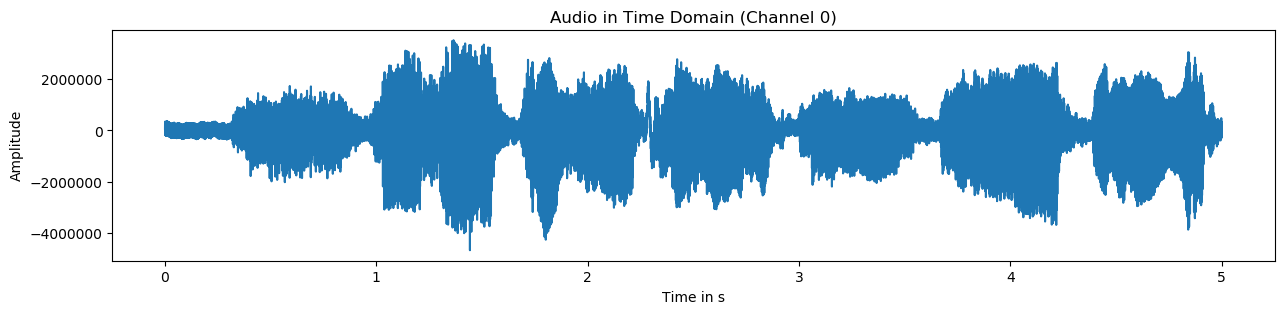

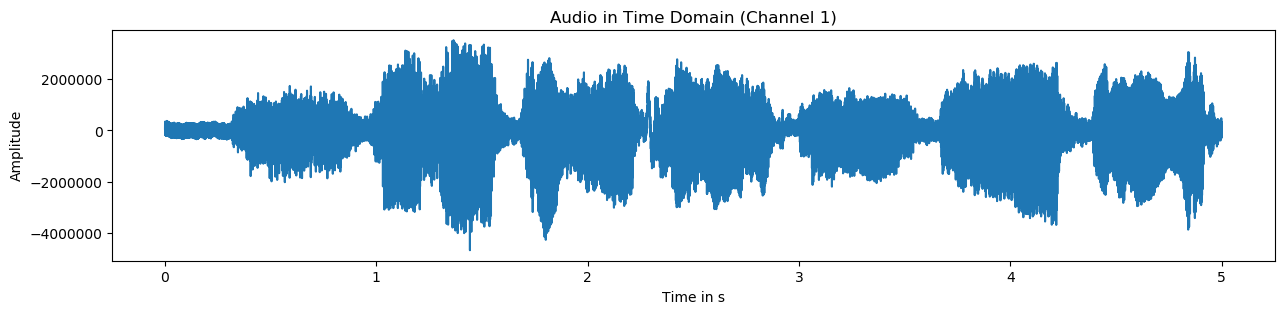

In [24]:
for channel_index in range(num_channels):
    plt.figure(num=None, figsize=(15, 3))
    plt.title('Audio in Time Domain (Channel {})'.format(channel_index))
    plt.xlabel('Time in s')
    plt.ylabel('Amplitude')
    time_axis = np.arange(0, num_frames/sample_rate, 1/sample_rate)
    plt.plot(time_axis, audio_with_interference[:, channel_index])
    matplotlib.style.use("default")
    plt.show()

Now compare the frequency response to the response from [earlier](#3.-Frequency-spectrum). Can you see a difference? 

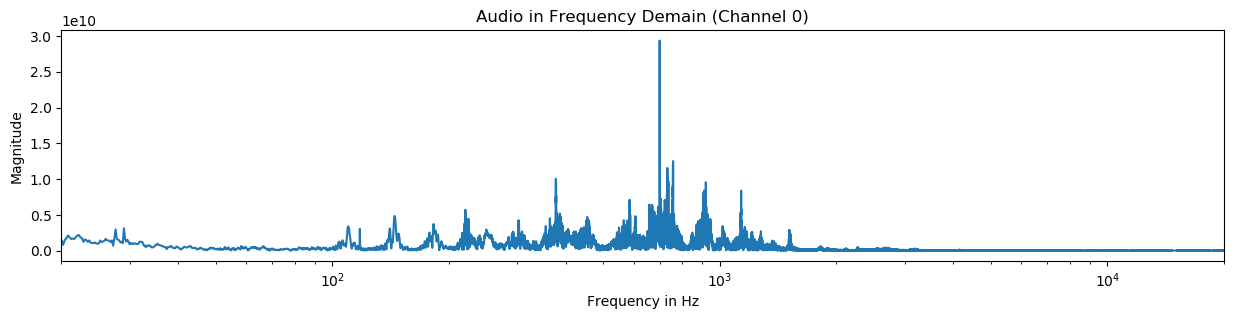

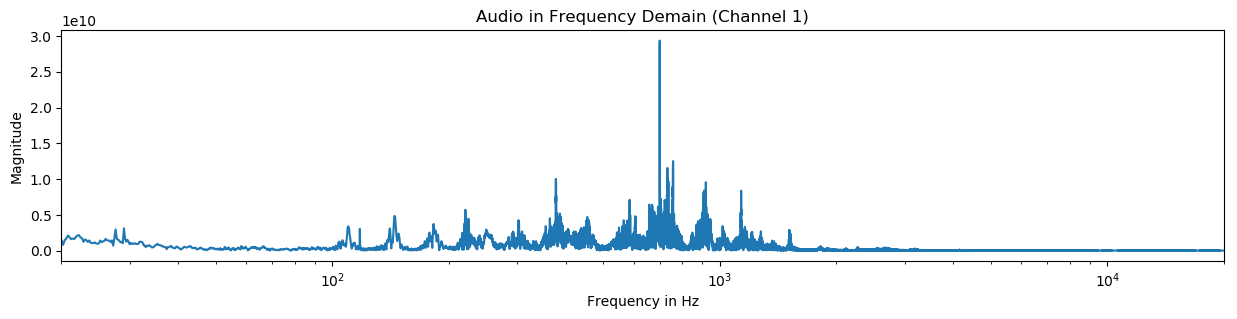

In [25]:
for channel_index in range(num_channels):
    plt.figure(num=None, figsize=(15, 3))
    plt.title('Audio in Frequency Demain (Channel {})'.format(channel_index))
    plt.xlabel('Frequency in Hz')
    plt.xscale('log')
    plt.ylabel('Magnitude')
    temp = fft(audio_with_interference[:, channel_index])
    yf = temp[1:len(temp)//2]
    xf = np.linspace(0.0, sample_rate/2, len(yf))
    plt.xlim(20,20000)
    plt.plot(xf, abs(yf))
    plt.show()

In [26]:
Audio(np.ascontiguousarray(np.transpose(audio_with_interference)), rate=48000)

### 3. Digital filtering
If we have particular frequency components that we do not desire in our signal, we can remove these through a process called *digital filtering*. Below are some functions defining common digital filters. 

In [27]:
from scipy import signal

def generate_lowpass(fs, cutoff, trans_width, numtaps):
    taps = signal.remez(numtaps, [0, cutoff, cutoff + trans_width, 0.5*fs], [1, 0], Hz=fs)
    w, h = signal.freqz(taps, [1], worN=2000)
    return w, h, taps

def generate_highpass(fs, cutoff, trans_width, numtaps):
    taps = signal.remez(numtaps, [0, cutoff - trans_width, cutoff, 0.5*fs], [0, 1], Hz=fs)
    w, h = signal.freqz(taps, [1], worN=2000)
    return w, h, taps

def generate_bandpass(fs, cutoff, trans_width, numtaps):
    edges = [0, cutoff[0] - trans_width, cutoff[0], cutoff[1], cutoff[1] + trans_width, 0.5*fs]
    taps = signal.remez(numtaps, edges, [0, 1, 0], Hz=fs)
    w, h = signal.freqz(taps, [1], worN=2000)
    return w, h, taps

def generate_bandstop(fs, cutoff, trans_width, numtaps):
    edges = [0, cutoff[0] - trans_width, cutoff[0], cutoff[1], cutoff[1] + trans_width, 0.5*fs]
    taps = signal.remez(numtaps, edges, [1, 0, 1], Hz=fs)
    w, h = signal.freqz(taps, [1], worN=2000)
    return w, h, taps

def plot_response(fs, w, h, title):
    "Utility function to plot response functions"
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(0.5*fs*w/np.pi, 20*np.log10(np.abs(h)))
    ax.set_ylim(-40, 5)
    ax.set_xlim(0, 0.5*fs)
    ax.grid(True)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Gain (dB)')
    ax.set_title(title)

We can plot the response of our digital filter to better visualise its characteristics. Frequencies with a gain of zero will not be effected by the filter, whereas frequencies with a negative gain will be suppressed. 

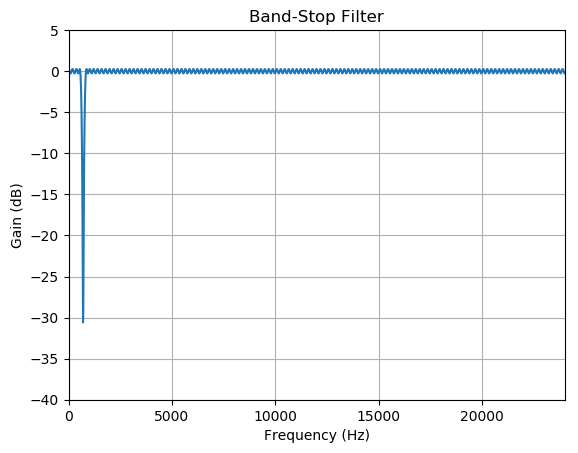

In [29]:
fs = sample_rate
cutoff = [695, 705]
transition = 125
number_taps = 501
w, h, coeffs = generate_bandstop(fs, cutoff, transition, number_taps)
plot_response(fs, w, h, title = "Band-Stop Filter")

Plotting the frequency response of the filtered signal, we can see the interference has been suppressed.

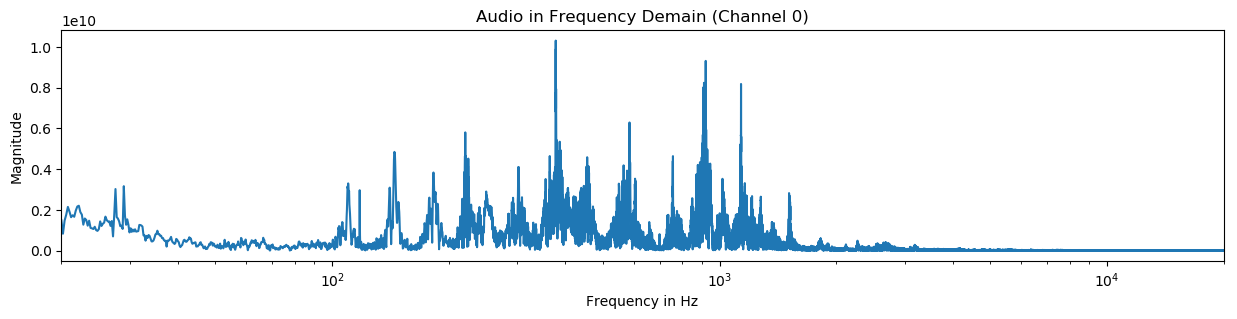

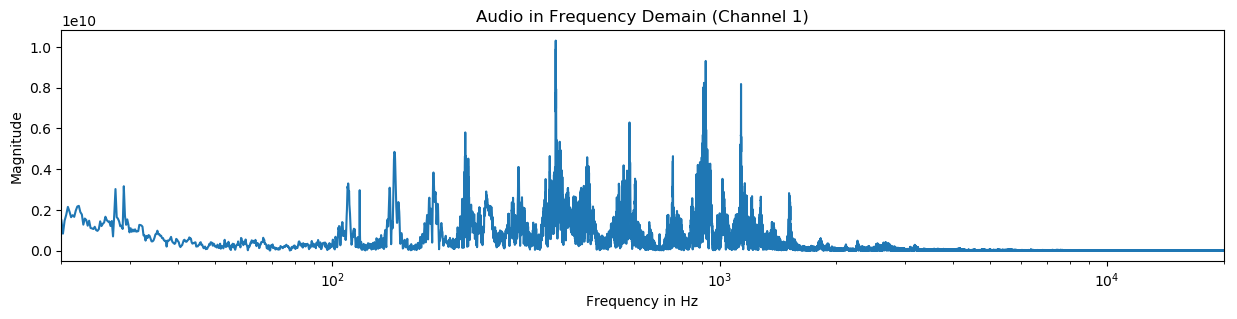

In [30]:
ch_0 = signal.lfilter(coeffs, [1], audio_with_interference[:, 0] / 2**18)
ch_1 = signal.lfilter(coeffs, [1], audio_with_interference[:, 1] / 2**18)
filtered_audio = (np.ascontiguousarray(np.transpose(np.asarray([ch_0, ch_1])))* 2**18).astype(int)

for channel_index in range(num_channels):
    plt.figure(num=None, figsize=(15, 3))
    plt.title('Audio in Frequency Demain (Channel {})'.format(channel_index))
    plt.xlabel('Frequency in Hz')
    plt.xscale('log')
    plt.ylabel('Magnitude')
    temp = fft(filtered_audio[:, channel_index])
    yf = temp[1:len(temp)//2]
    xf = np.linspace(0.0, sample_rate/2, len(yf))
    plt.xlim(20,20000)
    plt.plot(xf, abs(yf))
    plt.show()

We can listen to it to confirm with our ears also!

In [31]:
Audio(np.ascontiguousarray(np.transpose(filtered_audio)),rate=48000)

## Google's Speech API
### 1. Using Text to Speech
You can use this wrapper for Google's text-to-speech service to produce natural sounding speech.

In [32]:
words = "Hello World!"
tts = gTTS(words)
tts.save("data/hello.mp3")
mp3 = AudioSegment.from_mp3("data/hello.mp3")
mp3.export("data/hello.wav", format="wav")

<_io.BufferedRandom name='data/hello.wav'>

In [33]:
Audio("data/hello.wav")

### 2. Using Speech to Text
You can use this wrapper for Google's speech recognition service to extract words from an audio file.

In [50]:
pAudio.select_microphone()
pAudio.record(5)
pAudio.save("data/record_speech.wav")

In [51]:
r = sr.Recognizer()

with sr.AudioFile("data/record_speech.wav") as source:
    audio = r.record(source)

In [52]:
r.recognize_google(audio)

'I hope you enjoy the audio breakout session thank you for your time'